In [1]:
%matplotlib widget
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import numpy as np
import cv2
import json
import os

In [2]:
def get_source_matrix(filepath, exp_config):
    path_parts = filepath.split(os.sep)
    exp, barcode, date, snapshot, filename = path_parts[-5:]
    exp_id = exp.split("_")[0]
    zoom = filename.split("_")[3]
    with open(exp_config, "r") as fp:
        config = json.load(fp)
    mat_s = np.array(config[exp_id][zoom]["cc_matrix"])
    return mat_s

In [3]:
# Define workflow inputs
# TM018
# args = WorkflowInputs(images=["./random_samples/TM018_F_100416/Fa095AA034672/2016-10-12/snapshot212586/VIS_SV_0_z1_h1_g0_e65_v500_419003_0.png",
#                              "./random_samples/TM018_F_100416/Fa095AA034672/2016-10-12/snapshot212586/NIR_SV_0_z1_h1_g0_e18000_v500_419006_0.png"],
#                       names="vis,nir",
#                       result="results.json",
#                       outdir=".",
#                       writeimg=True,
#                       debug="plot")
args = WorkflowInputs(images=["./random_samples/TM018_F_100416/Fa160AB035064/2016-10-16/snapshot228912/VIS_SV_90_z1_h1_g0_e65_v500_451438_0.png",
                             "./random_samples/TM018_F_100416/Fa160AB035064/2016-10-16/snapshot228912/NIR_SV_90_z1_h1_g0_e18000_v500_451441_0.png"],
                      names="vis,nir",
                      result="results.json",
                      outdir=".",
                      writeimg=True,
                      debug="plot",
                      **{"config": "dataset_config.json"})
# TM027
# args = WorkflowInputs(images=["./random_samples/TM027_F_091517/Fa159AB049436/2017-10-10/snapshot82852/VIS_SV_0_z1_h1_g0_e65_v500_165272_0.png",
#                              "./random_samples/TM027_F_091517/Fa159AB049436/2017-10-10/snapshot82852/NIR_SV_0_z1_h1_g0_e18000_v500_165275_0.png"],
#                       names="vis,nir",
#                       result="results.json",
#                       outdir=".",
#                       writeimg=True,
#                       debug="plot")

In [4]:
# Global parameters
pcv.params.debug = args.debug

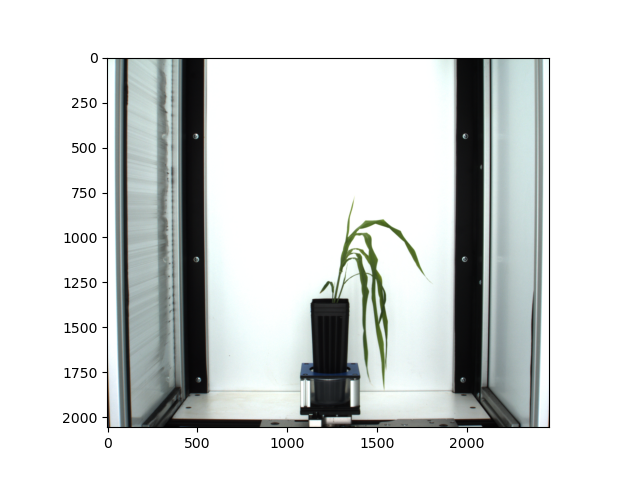

In [5]:
# Read the VIS image
rgb_img, rgb_path, rgb_filename = pcv.readimage(filename=args.vis)

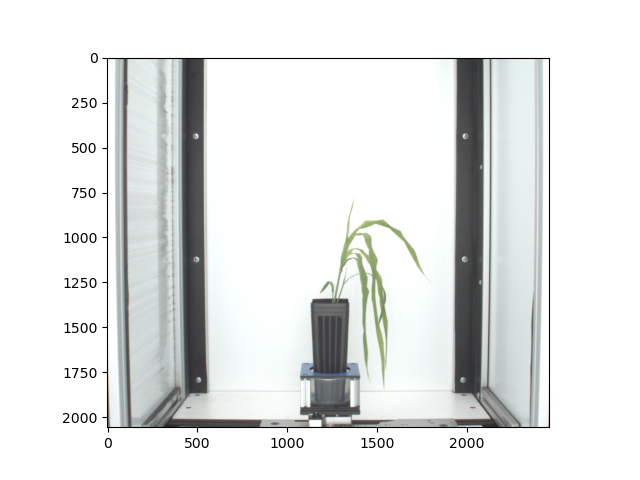

In [6]:
# Apply a gamma correction to linearize the white balance
gamma_img = pcv.transform.gamma_correct(img=rgb_img, gamma=0.45, gain=1)

In [7]:
# Target and source matrices for color correction
mat_t = pcv.transform.std_color_matrix(pos=3)
mat_s = get_source_matrix(args.vis, args.config)

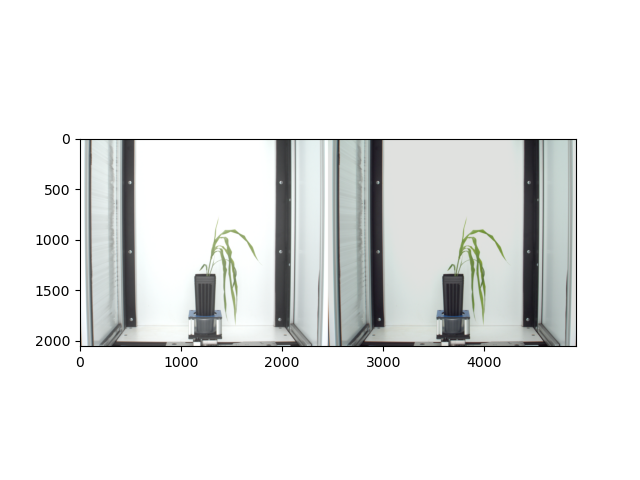

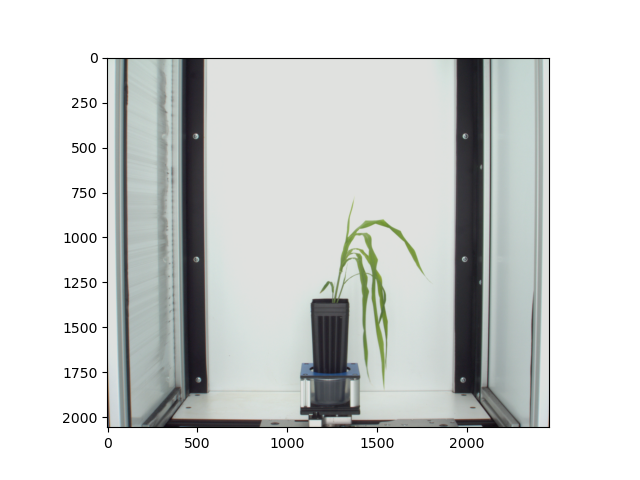

In [8]:
# Apply an affine color correction
img_cc = pcv.transform.affine_color_correction(rgb_img=gamma_img, source_matrix=mat_s, target_matrix=mat_t)
pcv.plot_image(img_cc)

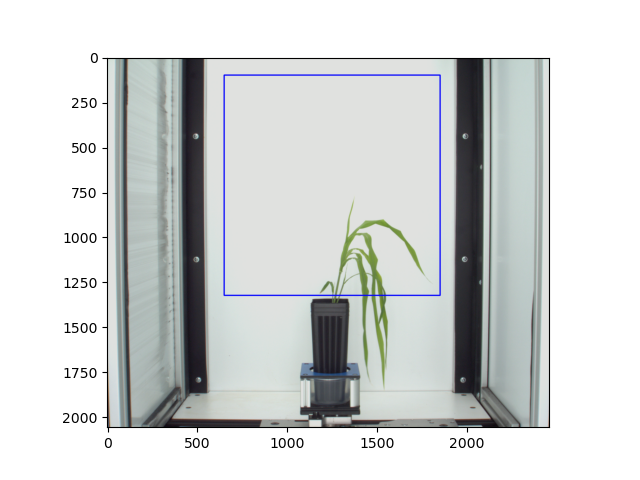

In [9]:
# Set the region of interest
#roi, roi_str = pcv.roi.rectangle(img=img_cc, x=650, y=100, h=1225, w=1200)
roi = pcv.roi.rectangle(img=img_cc, x=650, y=100, h=1225, w=1200)

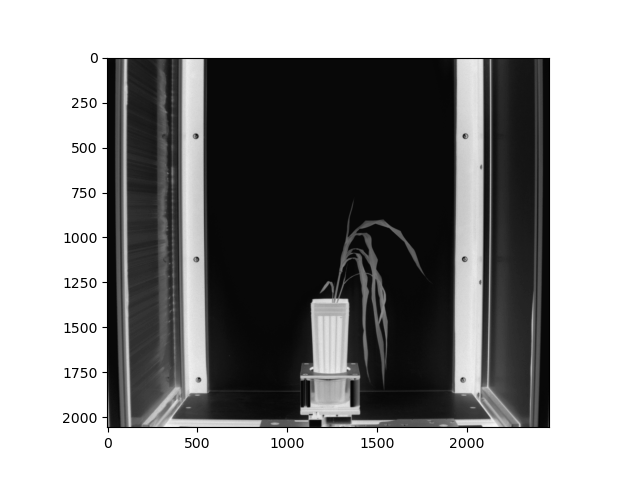

In [10]:
bkgd = pcv.rgb2gray_cmyk(rgb_img=img_cc, channel="k")

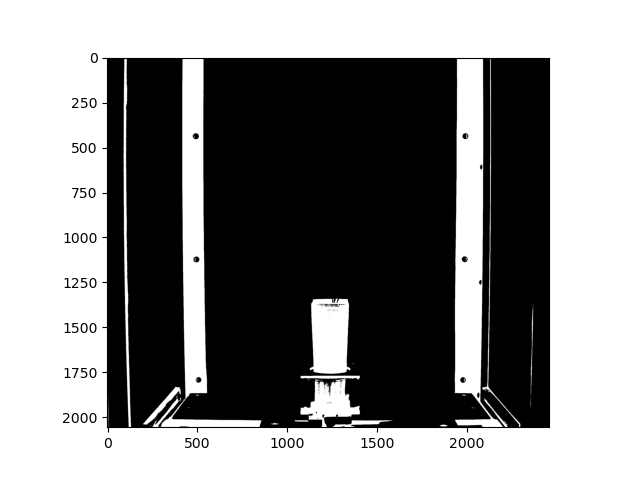

In [11]:
bkgd_mask = pcv.threshold.binary(gray_img=bkgd, threshold=165, max_value=255, object_type="light")

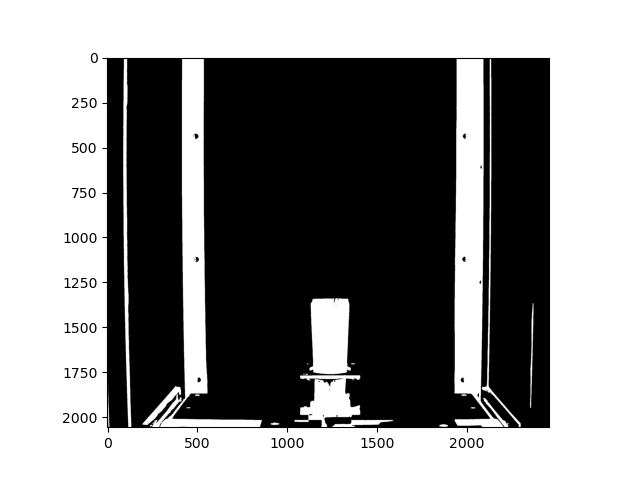

In [12]:
bkgd_mask = pcv.dilate(gray_img=bkgd_mask, ksize=5, i=1)

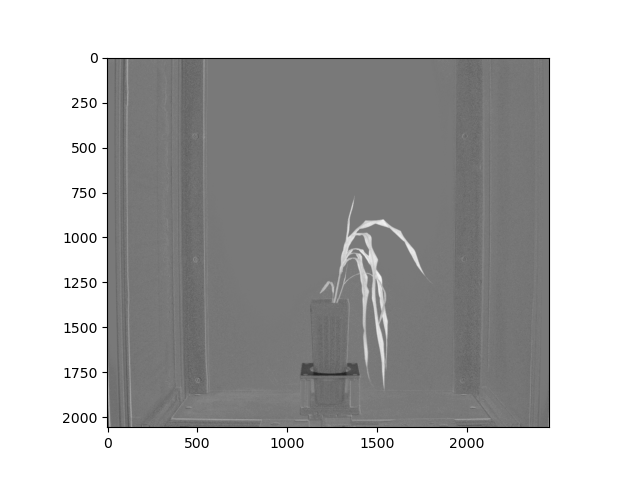

In [13]:
gray_img = pcv.rgb2gray_lab(rgb_img=img_cc, channel="b")

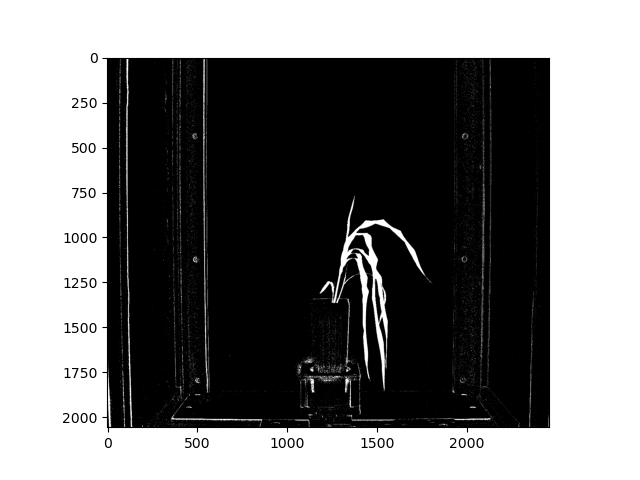

In [14]:
bin_img = pcv.threshold.mean(gray_img=gray_img, block_size=100, offset=-5, object_type="light")

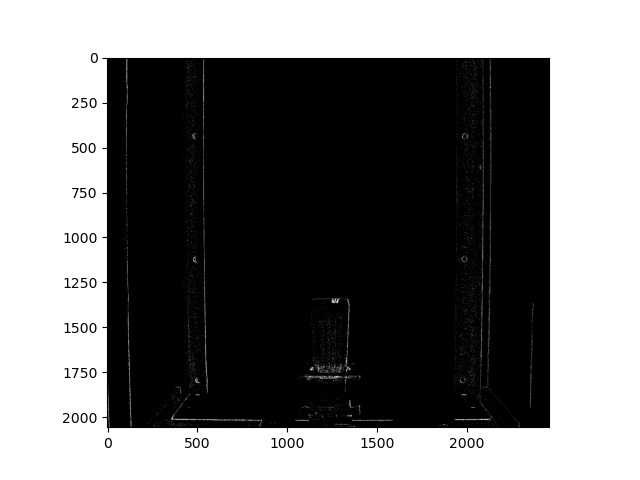

In [15]:
bkgd_overlap = pcv.logical_and(bin_img1=bkgd_mask, bin_img2=bin_img)

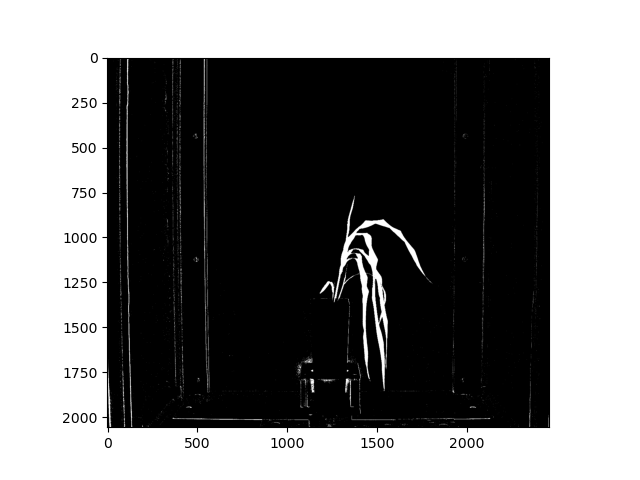

In [16]:
remove_overlap = bin_img - bkgd_overlap
pcv.plot_image(remove_overlap)

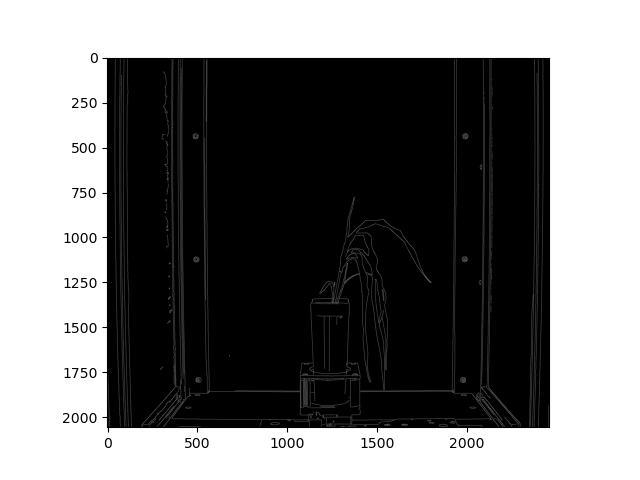

In [17]:
edges = pcv.canny_edge_detect(img=img_cc)

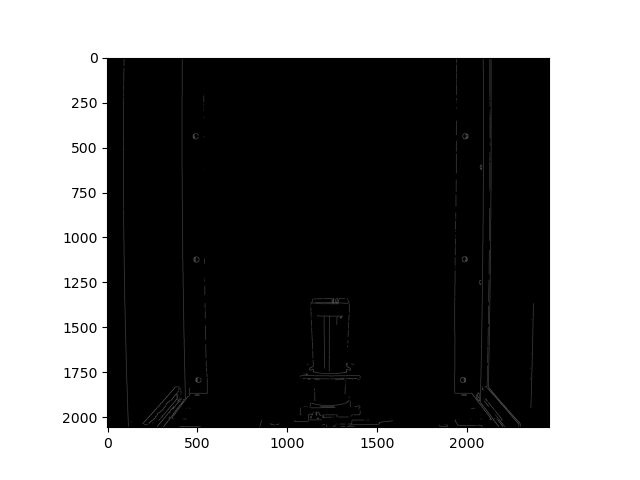

In [18]:
edges_overlap = pcv.logical_and(bin_img1=bkgd_mask, bin_img2=edges)

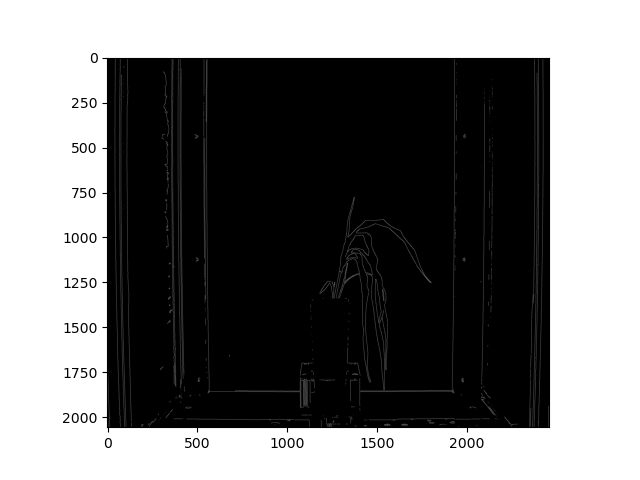

In [19]:
remove_overlap_edges = edges - edges_overlap
pcv.plot_image(remove_overlap_edges)

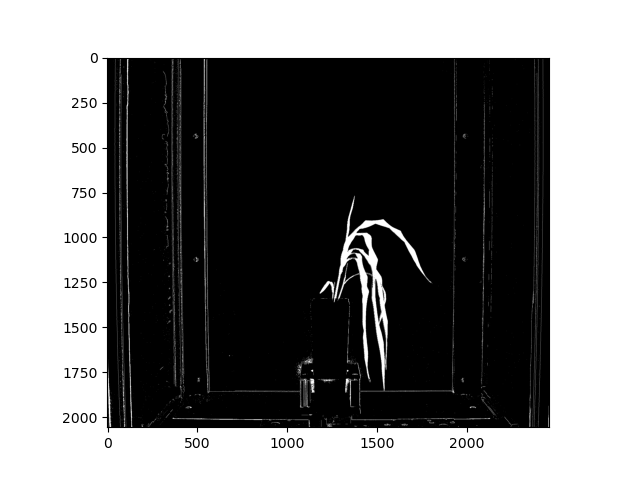

In [20]:
combine = pcv.logical_or(bin_img1=remove_overlap, bin_img2=remove_overlap_edges)

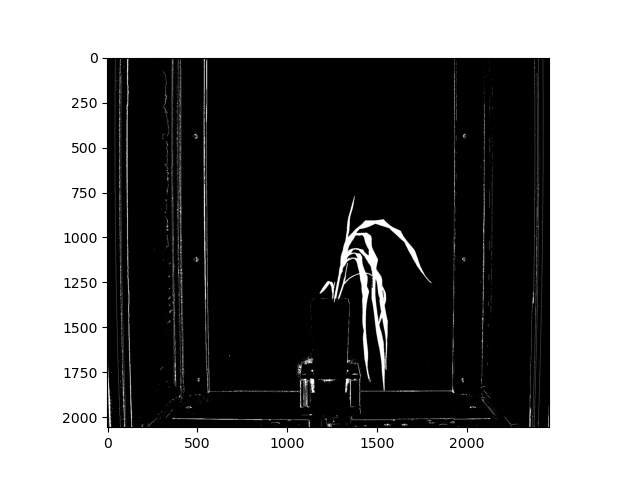

In [21]:
fill_gaps = pcv.closing(gray_img=combine)

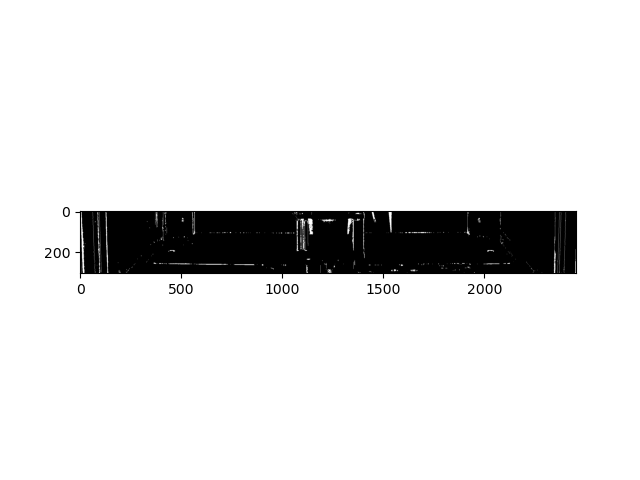

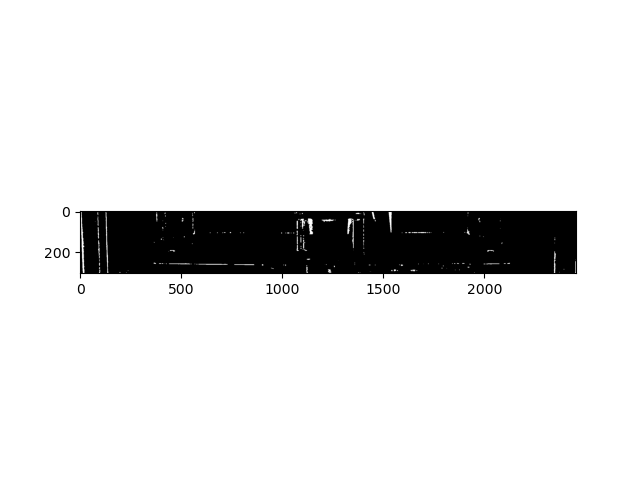

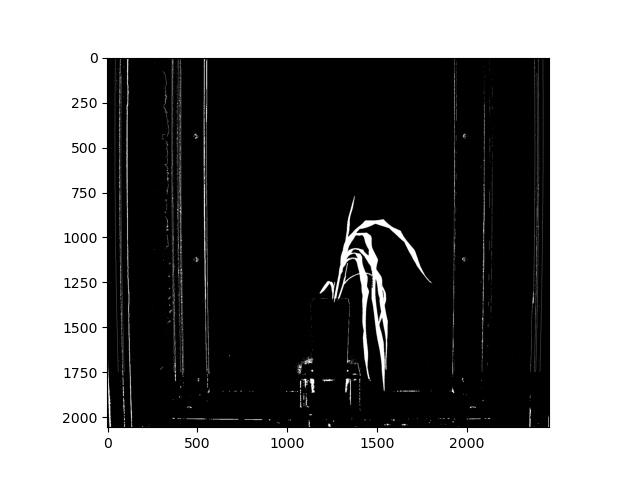

In [22]:
bot_img = fill_gaps[1750:, :]
bot_blur = pcv.median_blur(gray_img=bot_img, ksize=(5, 1))
bot_blur = pcv.median_blur(gray_img=bot_blur, ksize=(1, 5))
blur_img = fill_gaps.copy()
blur_img[1750:, :] = bot_blur
pcv.plot_image(blur_img)

/Users/nfahlgren/GitHub/plantcv/plantcv/plantcv/plot_image.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


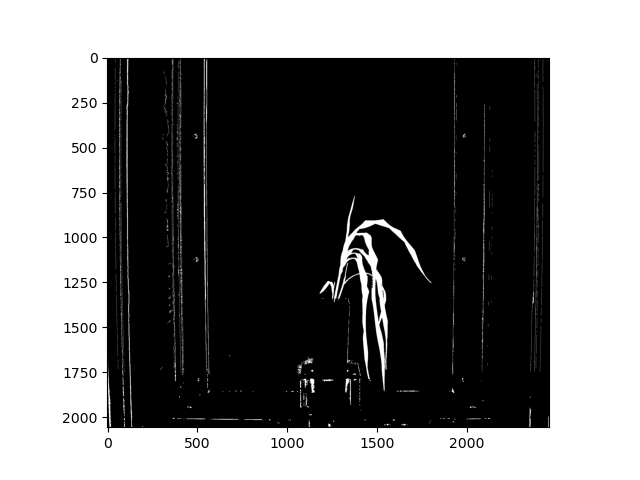

In [23]:
clean_bin = pcv.fill(bin_img=blur_img, size=10)

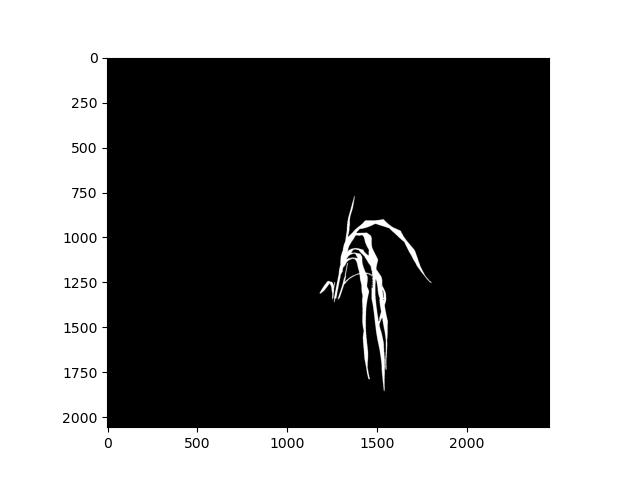

In [24]:
plant_mask = pcv.roi.filter(mask=clean_bin, roi=roi)

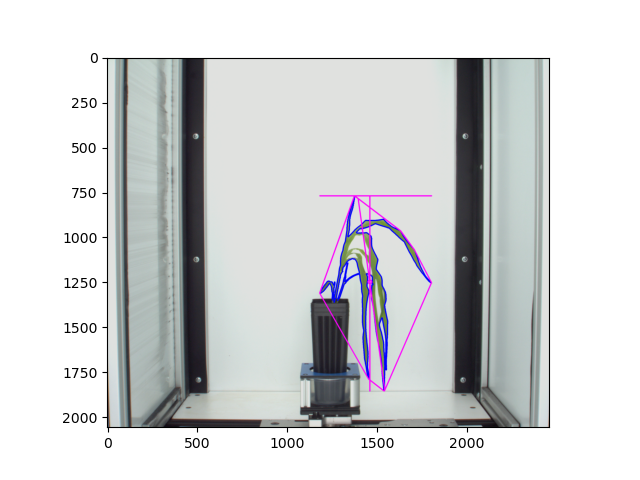

In [25]:
shape_img = pcv.analyze.size(img=img_cc, labeled_mask=plant_mask)

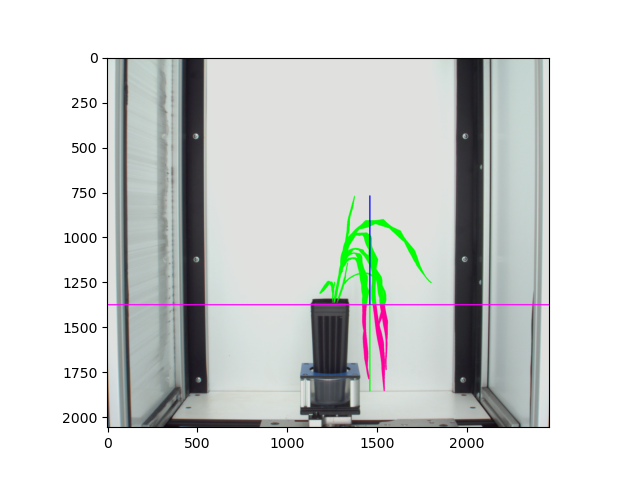

In [26]:
hline_img = pcv.analyze.bound_horizontal(img=img_cc, labeled_mask=plant_mask, line_position=1380)

In [27]:
hist = pcv.analyze.color(rgb_img=img_cc, labeled_mask=plant_mask, colorspaces="hsv")

alt.FacetChart(...)

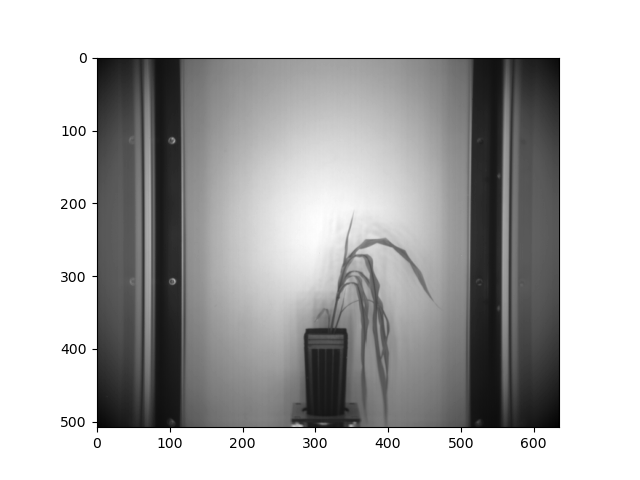

In [28]:
nir, nir_path, nir_filename = pcv.readimage(filename=args.nir)

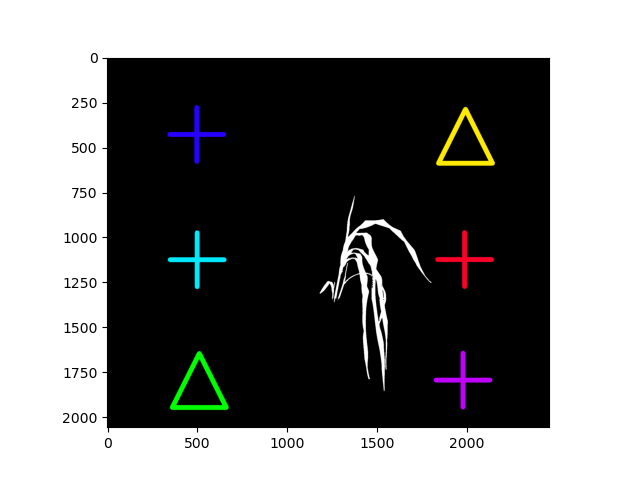

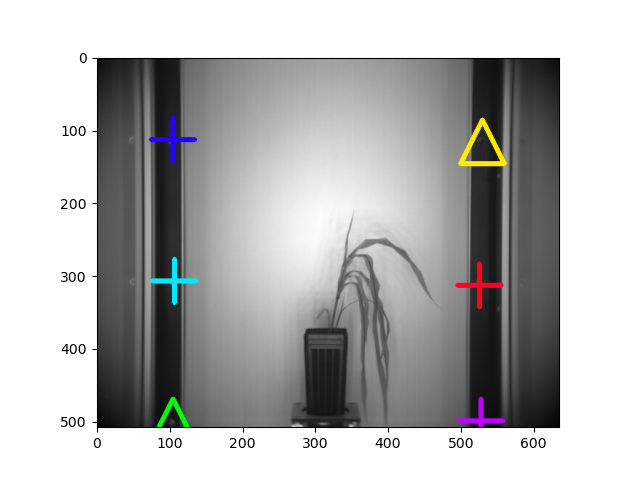

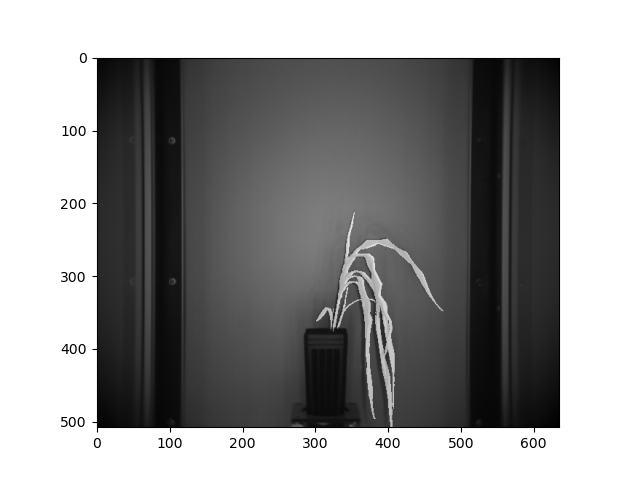

In [29]:
warped_mask, warp_mat = pcv.transform.warp(img=plant_mask, refimg=nir,
                                           pts=[(498,430), (500,1126), (512,1797), (1990,440), (1985,1125), (1976,1795)],
                                           refpts=[(104,113), (106,307), (104,499), (529,116), (525,313), (527,499)],
                                           method='lmeds')

In [30]:
nir_hist = pcv.analyze.grayscale(gray_img=nir, labeled_mask=warped_mask)

alt.FacetChart(...)

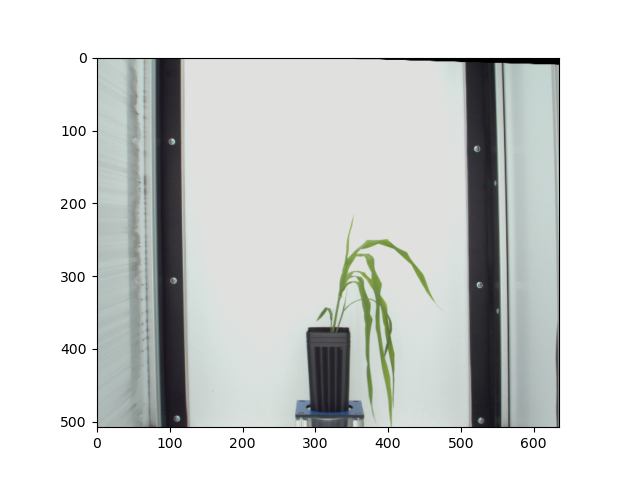

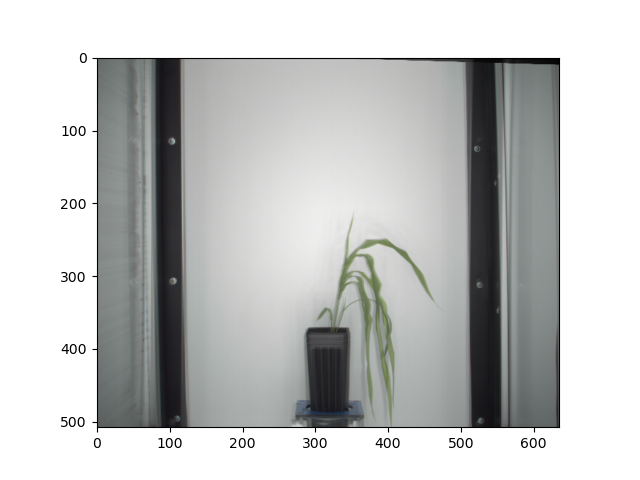

In [31]:
warp_img = pcv.transform.warp_align(img=img_cc, refimg=nir, mat=warp_mat)

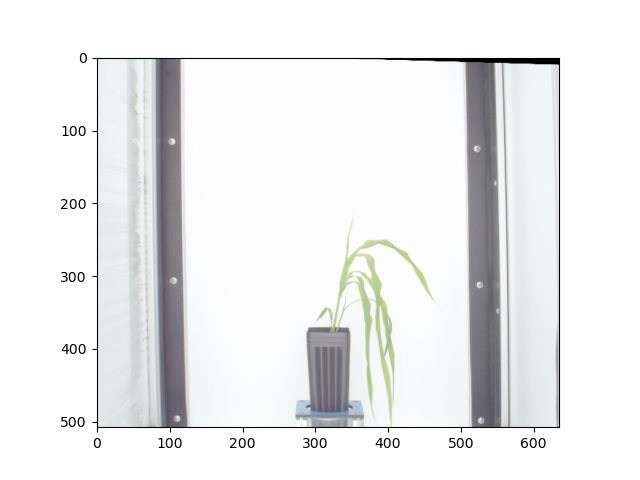

In [32]:
msi = pcv.image_fusion(img1=warp_img, img2=nir, wvs1=[480, 520, 700], wvs2=[800])

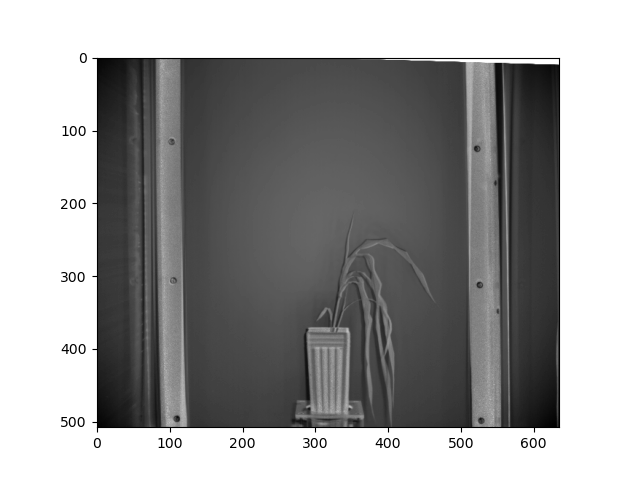

In [33]:
ndvi = pcv.spectral_index.ndvi(hsi=msi)

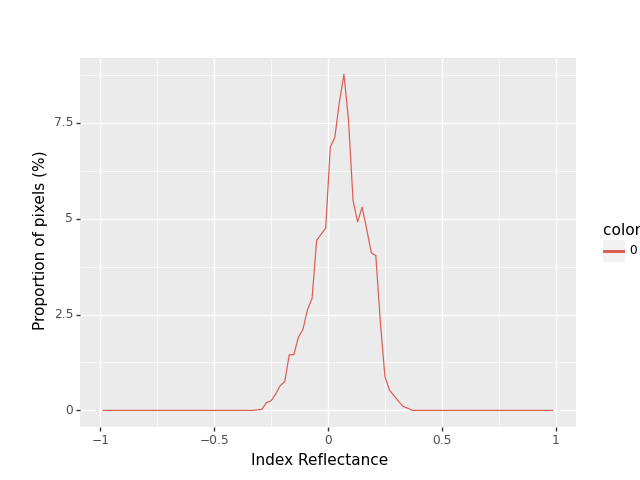

In [34]:
ndvi_hist = pcv.hyperspectral.analyze_index(index_array=ndvi, mask=warped_mask, min_bin=-1, max_bin=1)

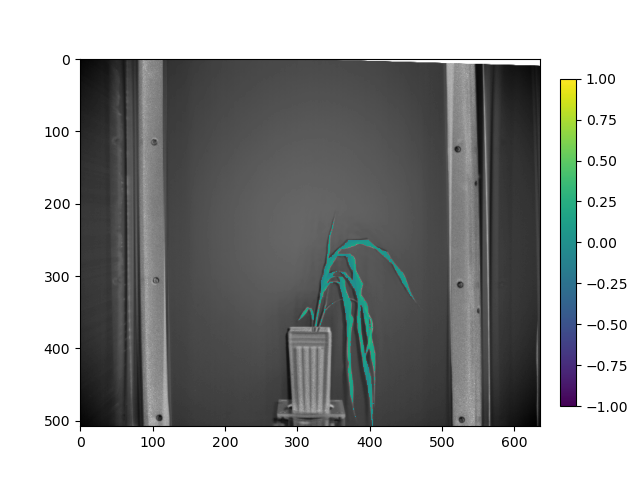

In [35]:
ps = pcv.visualize.pseudocolor(gray_img=ndvi.array_data, min_value=-1, max_value=1, mask=warped_mask)

In [36]:
pcv.outputs.save_results(args.result)